In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Data Preparation

In [20]:
# Load and filter data
df = pd.read_csv('/kaggle/input/sports-classification/sports.csv')
df = df[~df['filepaths'].str.endswith('.lnk')]  # Remove Windows shortcuts

# Split datasets
train_df = df[df['data set'] == 'train'].reset_index(drop=True)
val_df = df[df['data set'] == 'valid'].reset_index(drop=True)
test_df = df[df['data set'] == 'test'].reset_index(drop=True)

In [21]:
class SportsDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.valid_indices = self._find_valid_images()
        
    def _find_valid_images(self):
        valid_indices = []
        for idx in range(len(self.df)):
            try:
                img_path = f"/kaggle/input/sports-classification/{self.df.iloc[idx]['filepaths']}"
                with Image.open(img_path) as img:
                    img.verify()
                valid_indices.append(idx)
            except Exception:
                continue
        return valid_indices
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        img_path = f"/kaggle/input/sports-classification/{self.df.iloc[actual_idx]['filepaths']}"
        
        try:
            image = Image.open(img_path).convert('RGB')
            label = self.df.iloc[actual_idx]['class id']
            
            if self.transform:
                image = self.transform(image)
                
            return image, label
        except Exception:
            # Return random valid sample if error occurs
            return self[np.random.randint(0, len(self))]


In [22]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [23]:
train_dataset = SportsDataset(train_df, train_transform)
val_dataset = SportsDataset(val_df, val_test_transform)
test_dataset = SportsDataset(test_df, val_test_transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


# Model Setup

In [24]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_classes = len(df['class id'].unique())
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


#  Training Loop

In [25]:
num_epochs = 50
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Calculate metrics
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / total_train
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = correct_val / total_val
    
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    
    # Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}')
    print(f'Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}\n')


Epoch 1/50
Train Loss: 1.4702 | Val Loss: 1.4459
Train Acc: 0.6386 | Val Acc: 0.5980

Epoch 2/50
Train Loss: 0.5866 | Val Loss: 1.0034
Train Acc: 0.8392 | Val Acc: 0.7160

Epoch 3/50
Train Loss: 0.3725 | Val Loss: 0.8589
Train Acc: 0.8960 | Val Acc: 0.7380

Epoch 4/50
Train Loss: 0.2790 | Val Loss: 0.4868
Train Acc: 0.9205 | Val Acc: 0.8420

Epoch 5/50
Train Loss: 0.2119 | Val Loss: 0.5485
Train Acc: 0.9369 | Val Acc: 0.8520

Epoch 6/50
Train Loss: 0.1713 | Val Loss: 0.8530
Train Acc: 0.9509 | Val Acc: 0.7900

Epoch 7/50
Train Loss: 0.1750 | Val Loss: 0.5774
Train Acc: 0.9492 | Val Acc: 0.8440

Epoch 8/50
Train Loss: 0.1216 | Val Loss: 0.7514
Train Acc: 0.9641 | Val Acc: 0.8020

Early stopping at epoch 9


# Evaluation

In [26]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_loss = 0.0
correct_test = 0
total_test = 0
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        
        probs = torch.nn.functional.softmax(outputs, dim=1)
        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())
        
        _, predicted = torch.max(outputs.data, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

# Calculate final metrics
test_loss = test_loss / len(test_loader.dataset)
test_acc = correct_test / total_test
all_probs = torch.cat(all_probs).numpy()
all_labels = torch.cat(all_labels).numpy()

# ROC AUC Score
roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')

print('\nFinal Test Results:')
print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')


/tmp/ipykernel_31/2682214707.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Final Test Results:
Test Loss: 0.3896 | Test Acc: 0.8780
ROC AUC Score: 0.9995


 # Visualization

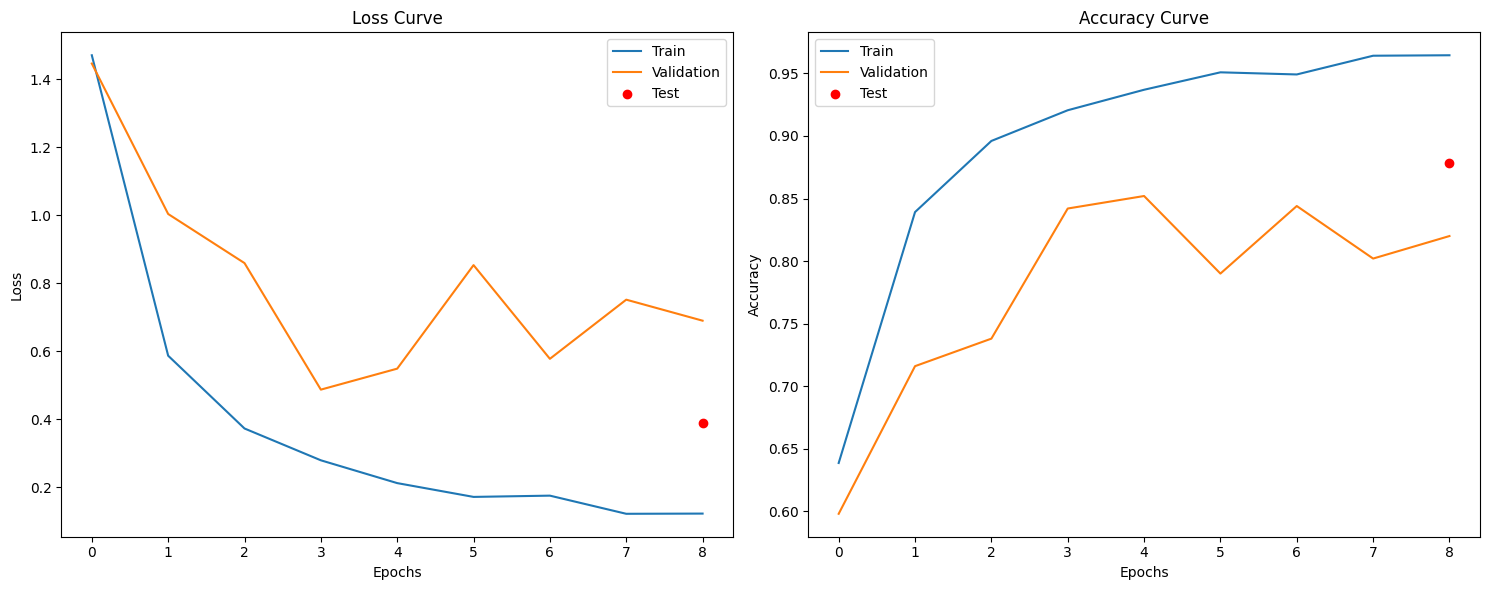

In [27]:
plt.figure(figsize=(15, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.scatter(len(train_losses)-1, test_loss, c='red', label='Test')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.scatter(len(train_accs)-1, test_acc, c='red', label='Test')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import numpy as np
import os

class SportsClassifier:
    def __init__(self, model_path, csv_path, device='cuda'):
        # Set device
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        
        # Load class mapping
        self.df = pd.read_csv(csv_path)
        self.classes = self.df[['class id', 'labels']].drop_duplicates().sort_values('class id')
        self.id_to_label = dict(zip(self.classes['class id'], self.classes['labels']))
        
        # Load model
        self.model = self._load_model(model_path)
        self.transform = self._get_transforms()
        
    def _load_model(self, model_path):
        # Recreate model architecture
        model = models.resnet18(weights=None)
        num_classes = len(self.id_to_label)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        
        # Load weights
        model.load_state_dict(torch.load(model_path, map_location=self.device))
        model = model.to(self.device)
        model.eval()
        return model
    
    def _get_transforms(self):
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    def _preprocess_image(self, image_path):
        try:
            # Handle Windows shortcuts
            if image_path.endswith('.lnk'):
                raise ValueError("Windows shortcut files not supported")
                
            image = Image.open(image_path).convert('RGB')
            return self.transform(image).unsqueeze(0)
        except Exception as e:
            print(f"Error processing {image_path}: {str(e)}")
            return None
    
    def predict(self, image_path):
        # Preprocess
        input_tensor = self._preprocess_image(image_path)
        if input_tensor is None:
            return None
            
        # Predict
        with torch.no_grad():
            input_tensor = input_tensor.to(self.device)
            outputs = self.model(input_tensor)
            probs = torch.nn.functional.softmax(outputs, dim=1)
        
        # Get results
        conf, class_id = torch.max(probs, 1)
        return {
            'class_id': class_id.item(),
            'label': self.id_to_label[class_id.item()],
            'confidence': conf.item(),
            'probabilities': probs.cpu().numpy()[0]
        }
    
    def predict_batch(self, image_dir):
        results = []
        valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
        
        for img_file in os.listdir(image_dir):
            img_path = os.path.join(image_dir, img_file)
            if os.path.splitext(img_file)[1].lower() not in valid_extensions:
                continue
                
            result = self.predict(img_path)
            if result:
                results.append((img_file, result))
        
        return results

# Example Usage
if __name__ == "__main__":
    # Initialize classifier
    classifier = SportsClassifier(
        model_path='best_model.pth',
        csv_path='/kaggle/input/sports-classification/sports.csv'
    )
    
    # Single image prediction
    image_path = '/kaggle/input/sports-classification/valid/arm wrestling/1.jpg'
    prediction = classifier.predict(image_path)
    if prediction:
        print(f"Prediction for {image_path}:")
        print(f"Class: {prediction['label']} (ID: {prediction['class_id']})")
        print(f"Confidence: {prediction['confidence']:.4f}")
    
    # Batch prediction
    image_dir = '/kaggle/input/sports-classification/valid/archery'
    batch_results = classifier.predict_batch(image_dir)
    print("\nBatch predictions:")
    for filename, result in batch_results:
        print(f"{filename}: {result['label']} ({result['confidence']:.2f})")

/tmp/ipykernel_31/715857125.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=self.device))


Prediction for /kaggle/input/sports-classification/valid/arm wrestling/1.jpg:
Class: arm wrestling (ID: 3)
Confidence: 0.9987

Batch predictions:
5.jpg: archery (1.00)
1.jpg: archery (0.50)
4.jpg: archery (0.97)
3.jpg: archery (0.92)
2.jpg: tennis (0.60)
